https://archive.ics.uci.edu/ml/datasets/Air+Quality

**Attribute Information:**

0. Date (DD/MM/YYYY)
1. Time (HH.MM.SS)
2. True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5. True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7. True hourly averaged NOx concentration in ppb (reference analyzer)
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12. Temperature in Â°C
13. Relative Humidity (%)
14. AH Absolute Humidity

In [1]:
# import required libraries

# data preprocessing
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest

# visualization
from matplotlib import pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 6.0)

# implementing deep learning model
import tensorflow as ts
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model 

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


### Data Preprocessing

In [2]:
# read data and print information of the set
data = pd.read_csv("AirQualityUCI\AirQualityUCI.csv")
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [3]:
# drop duplicates and reset index
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True,drop=True)
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [4]:
# combine date and time columns and set as index
data["Date Time"]=pd.to_datetime((data["Date"]+" "+data["Time"]),format="%d/%m/%Y %H.%M.%S")
data.set_index("Date Time",inplace=True)
data.drop(["Date","Time"],axis=1,inplace=True)
data.index

DatetimeIndex(['2004-03-10 18:00:00', '2004-03-10 19:00:00',
               '2004-03-10 20:00:00', '2004-03-10 21:00:00',
               '2004-03-10 22:00:00', '2004-03-10 23:00:00',
               '2004-03-11 00:00:00', '2004-03-11 01:00:00',
               '2004-03-11 02:00:00', '2004-03-11 03:00:00',
               ...
               '2005-04-04 05:00:00', '2005-04-04 06:00:00',
               '2005-04-04 07:00:00', '2005-04-04 08:00:00',
               '2005-04-04 09:00:00', '2005-04-04 10:00:00',
               '2005-04-04 11:00:00', '2005-04-04 12:00:00',
               '2005-04-04 13:00:00', '2005-04-04 14:00:00'],
              dtype='datetime64[ns]', name='Date Time', length=9357, freq=None)

In [5]:
# check the dataset frequency
display(data.head())
print("Dataset time index frequency: ",pd.infer_freq(data.index))

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


Dataset time index frequency:  H


In [6]:
col_names = list(data.columns)
colors = ['greenyellow','deeppink','deepskyblue','orange','red','royalblue','gold','brown','lime','darkviolet','navy','tomato','turquoise']
n_features = 13

In [7]:
# scale data
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(data)

In [8]:
# train and test split
test_size = 360
train = data_scaled[:-test_size,:]
test = data_scaled[-test_size:,:]
print("Train size: ",train.shape)
print("Test size: ",test.shape)

Train size:  (8997, 13)
Test size:  (360, 13)


In [9]:
def plot_features(data, col_names, colors, n_features):
    for i in range(n_features):
        plt.plot(data[:,i],color=colors[i])
        plt.title(col_names[i])
        plt.show() 

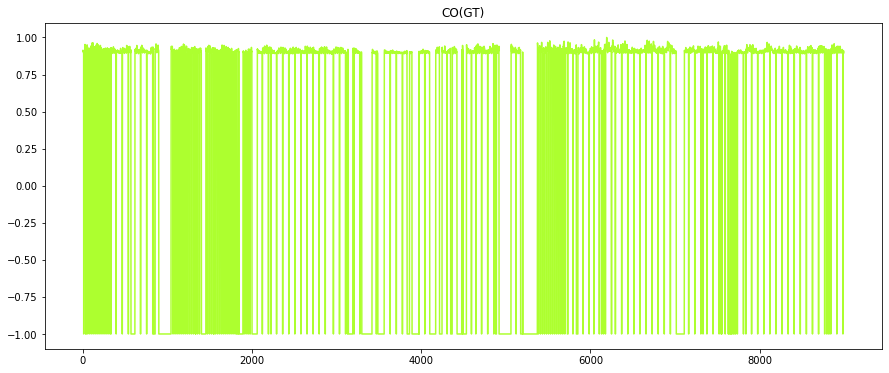

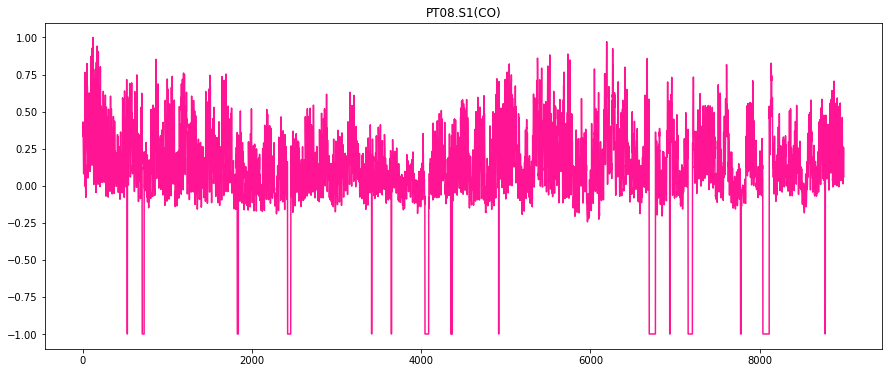

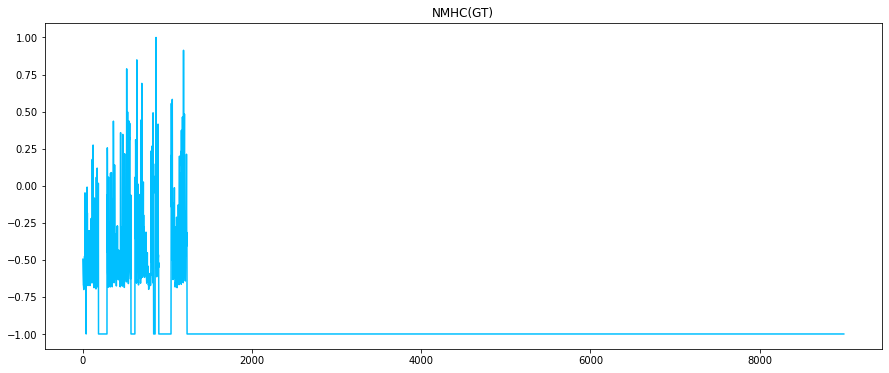

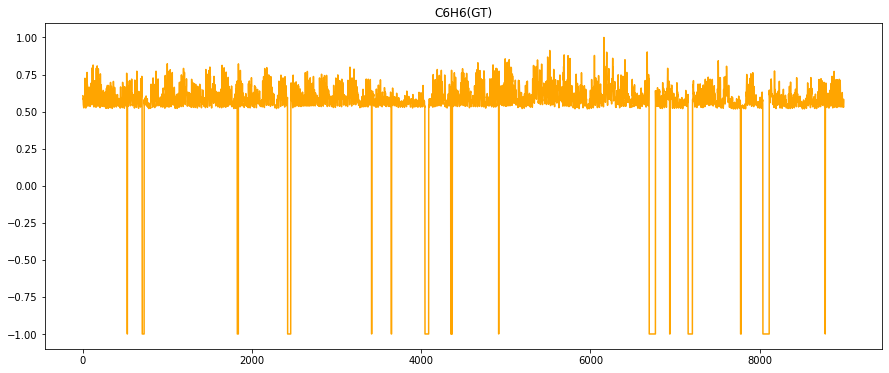

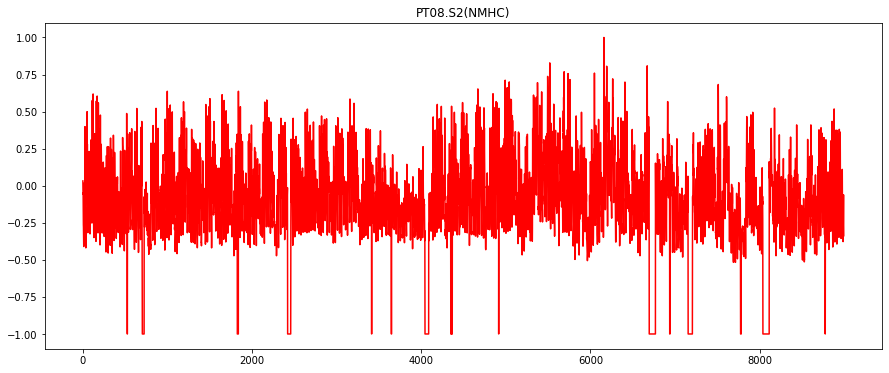

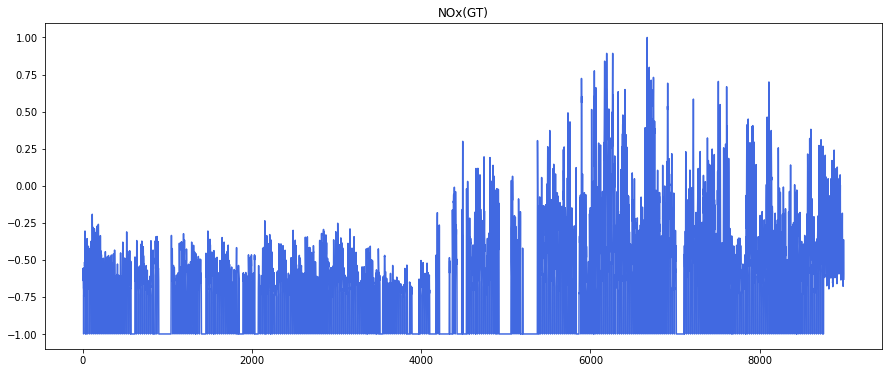

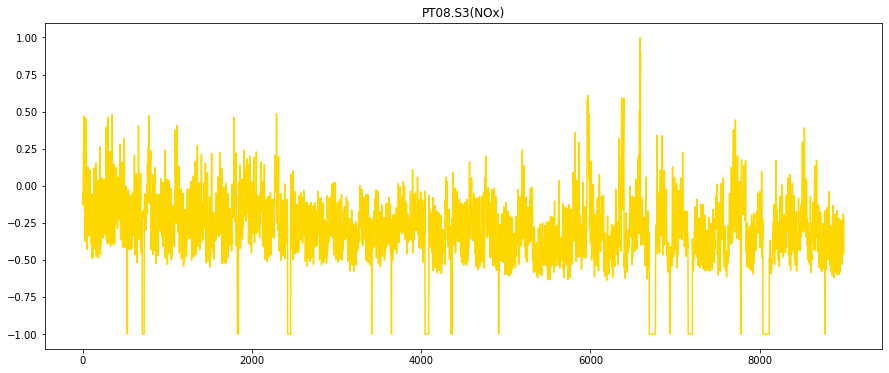

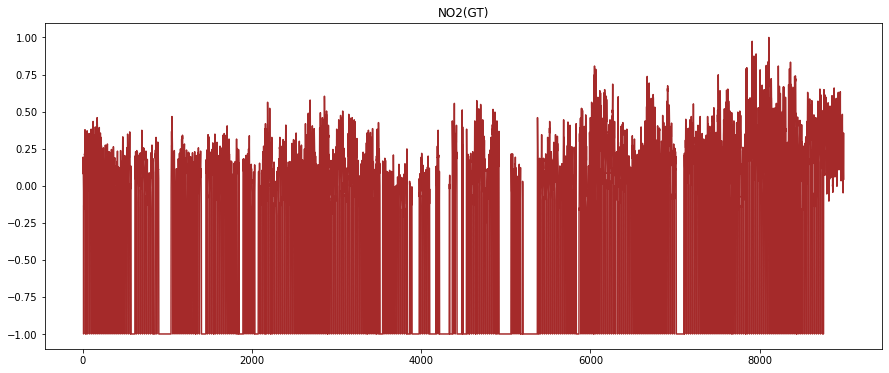

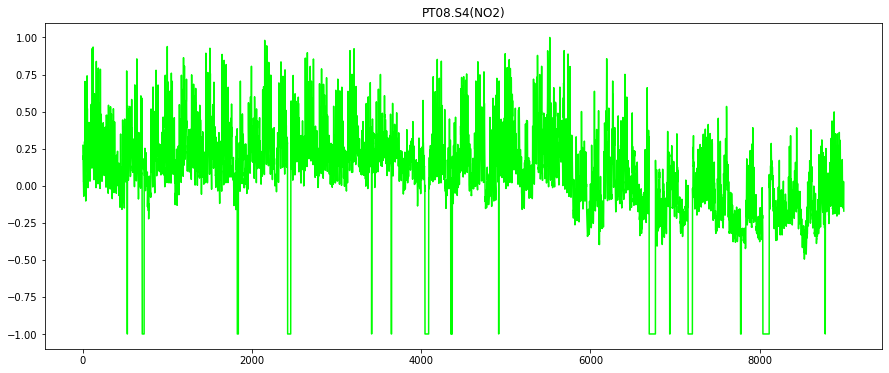

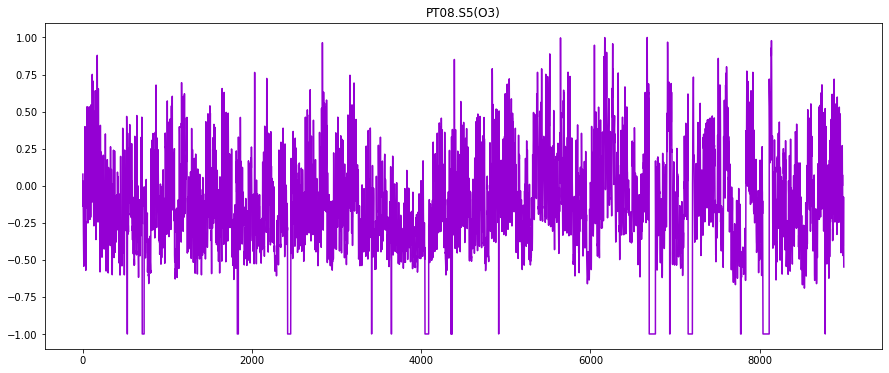

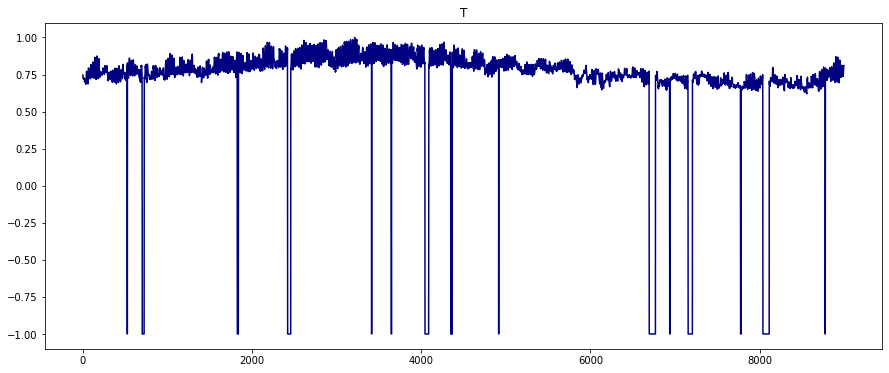

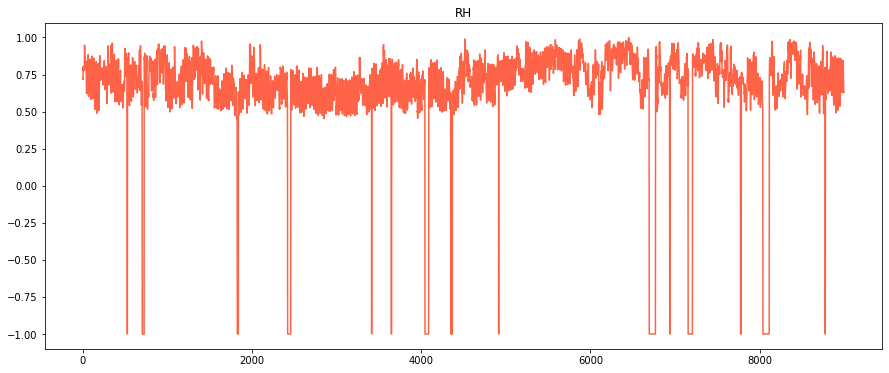

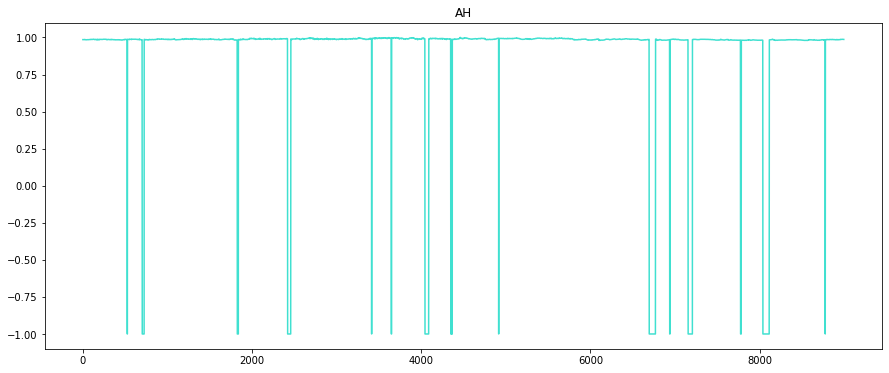

In [10]:
plot_features(train,col_names,colors,n_features)

### Anomaly Handling

In [11]:
# boxplot and histogram plots
def plot_histogram(y,x,train,column_names,colors,n_features):
    plt.figure(figsize=(25,20))
    for i in range(train.shape[1]):
        plt.subplot(y,x,i+1)
        plt.hist(train[:,i],color=colors[i])
        plt.title(col_names[i])
    plt.show()

def plot_boxplot(y,x,train,column_names,colors,n_features):
    plt.figure(figsize=(25,20))
    for i in range(train.shape[1]):
        plt.subplot(y,x,i+1)
        plt.boxplot(train[:,i])
        plt.title(col_names[i])
    plt.show()

In [12]:
# plot_histogram(4,4,train,col_names,colors,n_features)
# plot_boxplot(4,4,train,col_names,colors,n_features)

In [13]:
def remove_anomaly(train,index,anomaly_idx_list):
    for i in range(len(anomaly_idx_list)):
        size = 0
        mean = 0
        for j in range(anomaly_idx_list[i]-100,anomaly_idx_list[i]+101):
            if(train.shape[0]-101>=j>=0 and j not in anomaly_idx_list ):
                size += 1
                mean += train[j,index]
#         print(mean/size)
        if size != 0:
            train[anomaly_idx_list[i],index] = mean/size
    return train

In [14]:
# isolation_forest = IsolationForest(contamination=0.02)

# for idx in range(train.shape[1]):
#     dt_feature = [[item] for item in train[:,idx]]
#     isolation_forest.fit(dt_feature)
#     pred = isolation_forest.predict(dt_feature)
#     anomaly = [i for i in range(len(pred)) if pred[i] == -1]
    
#     train = remove_anomaly(train,idx,anomaly)
    
#     anomaly_val = []
#     for i in range(len(anomaly)):
#         anomaly_val.append(dt_feature[anomaly[i]])
#     plt.plot(dt_feature,color='b')
#     plt.title(col_names[idx])
#     plt.scatter(anomaly,anomaly_val,color='r')
#     plt.legend(['original','anomaly'], loc='upper right')
#     plt.show()



### Model Implementation

In [15]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(0,len(sequences),n_steps_out):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [16]:
n_steps_in = 172
n_steps_out = 12
X_train, y_train = split_sequences(train,n_steps_in,n_steps_out)
X_test, y_test = split_sequences(test,n_steps_in,n_steps_out)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(735, 172, 13) (735, 12, 13)
(15, 172, 13) (15, 12, 13)


In [17]:
y_train = y_train.reshape(y_train.shape[0],n_steps_out*n_features)
y_test = y_test.reshape(y_test.shape[0],n_steps_out*n_features)
print(y_train.shape)
print(y_test.shape)

(735, 156)
(15, 156)


In [18]:
# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 100 == 0 and epoch > 0:
        lr = lr * 0.9    
    return lr

# early stopping and model chackpoint
learning_rate_scheduler = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor="val_loss",verbose=1,patience=100, mode="min",min_delta=0.00001)
model_checkpoint = ModelCheckpoint("best_model.h5",monitor="val_loss",verbose=1,save_best_only=True)


In [19]:
model = Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(n_steps_in,n_features)))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_steps_out*n_features))


In [20]:
# 
model.compile(optimizer=Adam(learning_rate=0.0008), loss="mse")
epochs = 10000
validation_split = 0.2 # 20% validation set
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=105,verbose=1,validation_split=validation_split,shuffle=False, callbacks=[learning_rate_scheduler,early_stopping,model_checkpoint])

Epoch 1/10000
6/6 [==============================] - ETA: 0s - loss: 0.4297
Epoch 1: val_loss improved from inf to 0.36101, saving model to best_model.h5
6/6 [==============================] - 17s 1s/step - loss: 0.4297 - val_loss: 0.3610 - lr: 8.0000e-04
Epoch 2/10000
6/6 [==============================] - ETA: 0s - loss: 0.3582
Epoch 2: val_loss improved from 0.36101 to 0.28013, saving model to best_model.h5
6/6 [==============================] - 4s 751ms/step - loss: 0.3582 - val_loss: 0.2801 - lr: 8.0000e-04
Epoch 3/10000
6/6 [==============================] - ETA: 0s - loss: 0.2831
Epoch 3: val_loss improved from 0.28013 to 0.20743, saving model to best_model.h5
6/6 [==============================] - 5s 861ms/step - loss: 0.2831 - val_loss: 0.2074 - lr: 8.0000e-04
Epoch 4/10000
6/6 [==============================] - ETA: 0s - loss: 0.2248
Epoch 4: val_loss improved from 0.20743 to 0.15709, saving model to best_model.h5
6/6 [==============================] - 5s 905ms/step - loss: 0

6/6 [==============================] - 5s 915ms/step - loss: 0.0822 - val_loss: 0.0638 - lr: 8.0000e-04
Epoch 33/10000
6/6 [==============================] - ETA: 0s - loss: 0.0824
Epoch 33: val_loss improved from 0.06384 to 0.06313, saving model to best_model.h5
6/6 [==============================] - 5s 922ms/step - loss: 0.0824 - val_loss: 0.0631 - lr: 8.0000e-04
Epoch 34/10000
6/6 [==============================] - ETA: 0s - loss: 0.0804
Epoch 34: val_loss did not improve from 0.06313
6/6 [==============================] - 5s 908ms/step - loss: 0.0804 - val_loss: 0.0633 - lr: 8.0000e-04
Epoch 35/10000
6/6 [==============================] - ETA: 0s - loss: 0.0794
Epoch 35: val_loss improved from 0.06313 to 0.06247, saving model to best_model.h5
6/6 [==============================] - 6s 927ms/step - loss: 0.0794 - val_loss: 0.0625 - lr: 8.0000e-04
Epoch 36/10000
6/6 [==============================] - ETA: 0s - loss: 0.0791
Epoch 36: val_loss improved from 0.06247 to 0.06035, saving mo

Epoch 67/10000
6/6 [==============================] - ETA: 0s - loss: 0.0634
Epoch 67: val_loss did not improve from 0.05492
6/6 [==============================] - 6s 955ms/step - loss: 0.0634 - val_loss: 0.0550 - lr: 8.0000e-04
Epoch 68/10000
6/6 [==============================] - ETA: 0s - loss: 0.0632
Epoch 68: val_loss did not improve from 0.05492
6/6 [==============================] - 6s 934ms/step - loss: 0.0632 - val_loss: 0.0551 - lr: 8.0000e-04
Epoch 69/10000
6/6 [==============================] - ETA: 0s - loss: 0.0623
Epoch 69: val_loss did not improve from 0.05492
6/6 [==============================] - 6s 935ms/step - loss: 0.0623 - val_loss: 0.0576 - lr: 8.0000e-04
Epoch 70/10000
6/6 [==============================] - ETA: 0s - loss: 0.0641
Epoch 70: val_loss did not improve from 0.05492
6/6 [==============================] - 6s 933ms/step - loss: 0.0641 - val_loss: 0.0607 - lr: 8.0000e-04
Epoch 71/10000
6/6 [==============================] - ETA: 0s - loss: 0.0631
Epoch 7

6/6 [==============================] - 6s 950ms/step - loss: 0.0543 - val_loss: 0.0588 - lr: 7.2000e-04
Epoch 103/10000
6/6 [==============================] - ETA: 0s - loss: 0.0535
Epoch 103: val_loss did not improve from 0.05251
6/6 [==============================] - 6s 949ms/step - loss: 0.0535 - val_loss: 0.0590 - lr: 7.2000e-04
Epoch 104/10000
6/6 [==============================] - ETA: 0s - loss: 0.0528
Epoch 104: val_loss did not improve from 0.05251
6/6 [==============================] - 6s 953ms/step - loss: 0.0528 - val_loss: 0.0577 - lr: 7.2000e-04
Epoch 105/10000
6/6 [==============================] - ETA: 0s - loss: 0.0534
Epoch 105: val_loss did not improve from 0.05251
6/6 [==============================] - 6s 961ms/step - loss: 0.0534 - val_loss: 0.0588 - lr: 7.2000e-04
Epoch 106/10000
6/6 [==============================] - ETA: 0s - loss: 0.0528
Epoch 106: val_loss did not improve from 0.05251
6/6 [==============================] - 6s 940ms/step - loss: 0.0528 - val_lo

6/6 [==============================] - ETA: 0s - loss: 0.0499
Epoch 138: val_loss did not improve from 0.05251
6/6 [==============================] - 5s 851ms/step - loss: 0.0499 - val_loss: 0.0586 - lr: 7.2000e-04
Epoch 139/10000
6/6 [==============================] - ETA: 0s - loss: 0.0496
Epoch 139: val_loss did not improve from 0.05251
6/6 [==============================] - 5s 847ms/step - loss: 0.0496 - val_loss: 0.0575 - lr: 7.2000e-04
Epoch 140/10000
6/6 [==============================] - ETA: 0s - loss: 0.0500
Epoch 140: val_loss did not improve from 0.05251
6/6 [==============================] - 5s 860ms/step - loss: 0.0500 - val_loss: 0.0575 - lr: 7.2000e-04
Epoch 141/10000
6/6 [==============================] - ETA: 0s - loss: 0.0486
Epoch 141: val_loss did not improve from 0.05251
6/6 [==============================] - 5s 849ms/step - loss: 0.0486 - val_loss: 0.0568 - lr: 7.2000e-04
Epoch 142/10000
6/6 [==============================] - ETA: 0s - loss: 0.0495
Epoch 142: val

6/6 [==============================] - 5s 849ms/step - loss: 0.0447 - val_loss: 0.0595 - lr: 7.2000e-04
Epoch 174/10000
6/6 [==============================] - ETA: 0s - loss: 0.0453
Epoch 174: val_loss did not improve from 0.05251
6/6 [==============================] - 5s 818ms/step - loss: 0.0453 - val_loss: 0.0562 - lr: 7.2000e-04
Epoch 175/10000
6/6 [==============================] - ETA: 0s - loss: 0.0450
Epoch 175: val_loss did not improve from 0.05251
6/6 [==============================] - 5s 806ms/step - loss: 0.0450 - val_loss: 0.0586 - lr: 7.2000e-04
Epoch 176/10000
6/6 [==============================] - ETA: 0s - loss: 0.0459
Epoch 176: val_loss did not improve from 0.05251
6/6 [==============================] - 5s 855ms/step - loss: 0.0459 - val_loss: 0.0592 - lr: 7.2000e-04
Epoch 177/10000
6/6 [==============================] - ETA: 0s - loss: 0.0450
Epoch 177: val_loss did not improve from 0.05251
6/6 [==============================] - 5s 829ms/step - loss: 0.0450 - val_lo

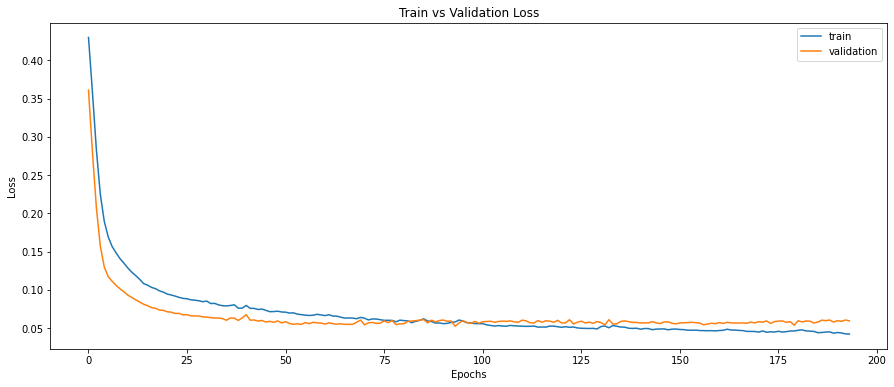

In [21]:
# plot the validation and training loss
plt.figure(figsize=(15,6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [22]:
# SAVE AND LOAD MODEL
# model.save("model2.h5")

# load model
model = load_model('best_model.h5')

In [23]:
# prediction
y_pred = np.zeros((y_test.shape[0],y_test.shape[1]))
X_test_model = X_test[0].copy()


# print(X_test[0],X_test.shape)
# print(X_test_model,X_test_model.shape)

In [24]:
for i in range(X_test.shape[0]):
    
#     print("Before\n")
#     print(X_test_model)
    X_test_model = X_test_model.reshape(1,n_steps_in,n_features)
#     print("Before\n")
#     print(X_test_model)
    pred = model.predict(X_test_model, verbose=0)
    X_test_model.reshape(n_steps_in,n_features)
#     print("Predicted\n")
#     print(pred)
#     print("Actual")
#     print(y_test[i])
    y_pred[i]=pred
#     print("y_pred all")
#     print(y_pred[i])
#     print("y_test all")
#     print(y_test[i])
    pred=pred.reshape(n_steps_out,n_features)
#     print(pred)
    if(n_steps_out>n_steps_in):
        X_test_model[0,:] = pred[-n_steps_in:]
    else:
        X_test_model[0,:-n_steps_out] = X_test_model[0,n_steps_out:]
        X_test_model[0,-n_steps_out:] = pred

#     X_test_model[0,:-n_steps_out] = X_test_model[0,n_steps_out:]
#     X_test_model[0,-n_steps_out:] = pred[-n_steps_in:]
#     print("After")
#     print(X_test_model)
    


In [25]:
# y_pred = y_pred.reshape(y_test.shape[0],n_steps_out*n_features)
# print(y_pred.shape)
y_pred_inv = np.zeros_like(y_pred)
y_test_inv = np.zeros_like(y_test)
for i in range(1,n_steps_out+1):
#     print(i)
    y_pred_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_pred[:,(i-1)*n_features:i*n_features])
#     print(scaler.inverse_transform(y_pred[0:3,(i-1)*n_features:i*n_features]))
#     print("--------------------------------------------------------- i= ",i)
#     print(y_pred_inv[0:3,:])
#     print("--------------------------------------------------------- test")
    
    
    y_test_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_test[:,(i-1)*n_features:i*n_features])
#     print(y_test_inv[0:10,:])
rmse = mean_squared_error(y_test_inv, y_pred_inv) ** (0.5)
print('Test RMSE: %.3f ' % rmse )

Test RMSE: 200.907 


In [26]:
y_test_re = y_test_inv.reshape(n_steps_out*y_test_inv.shape[0], n_features)
y_pred_re = y_pred_inv.reshape(n_steps_out*y_pred_inv.shape[0], n_features)
print(y_pred_re.shape)
print(y_test_re.shape)
rmse = mean_squared_error(y_test_re, y_pred_re) ** (0.5)
print('Test RMSE: %.3f ' % rmse )

(180, 13)
(180, 13)
Test RMSE: 200.907 


In [31]:
y_train_inv = np.zeros_like(y_train)
for i in range(1,n_steps_out+1):
    y_train_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_train[:,(i-1)*n_features:i*n_features])
y_train_re = y_train_inv.reshape(y_train.shape[0]*n_steps_out,n_features)
print(y_train_re.shape)

(8820, 13)


In [27]:
# print(y_pred_re[:10,])
# print(y_test_re[:10,])

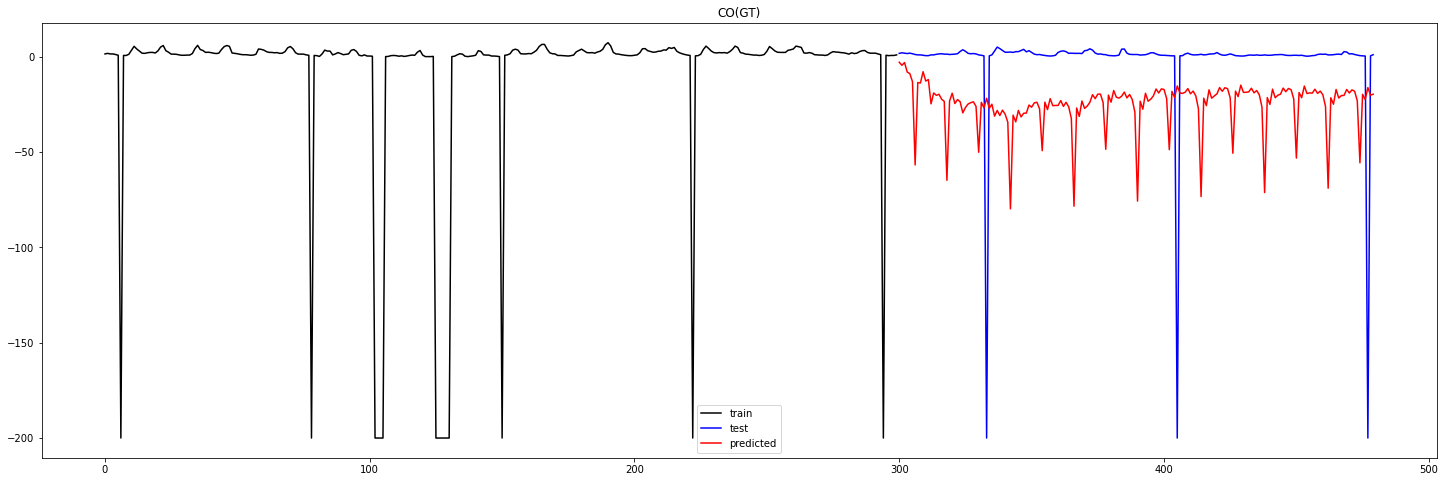

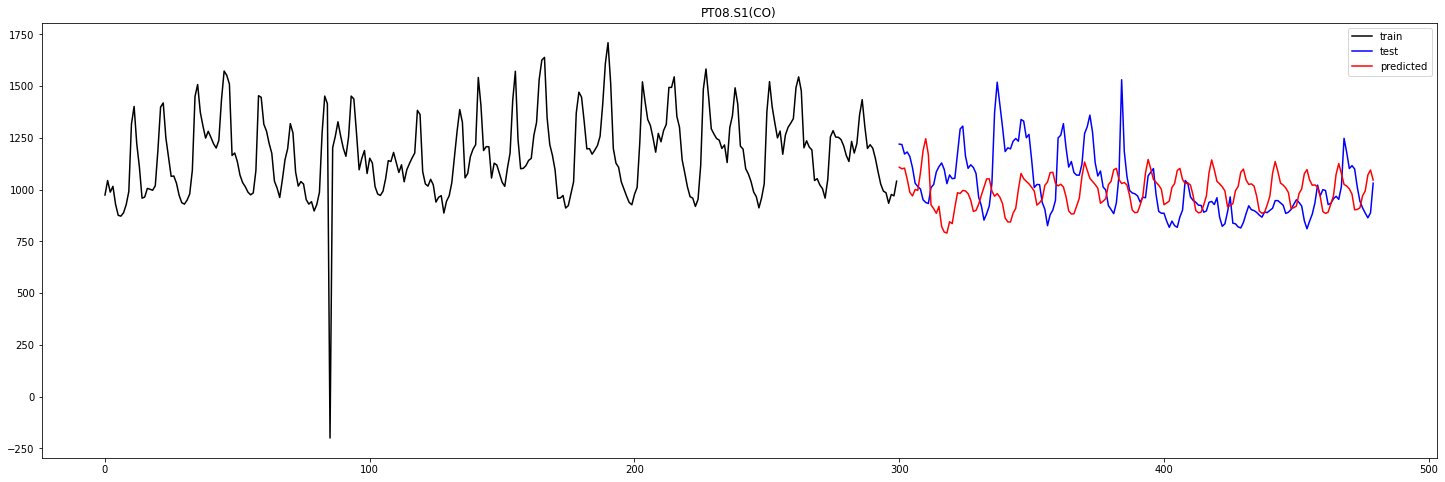

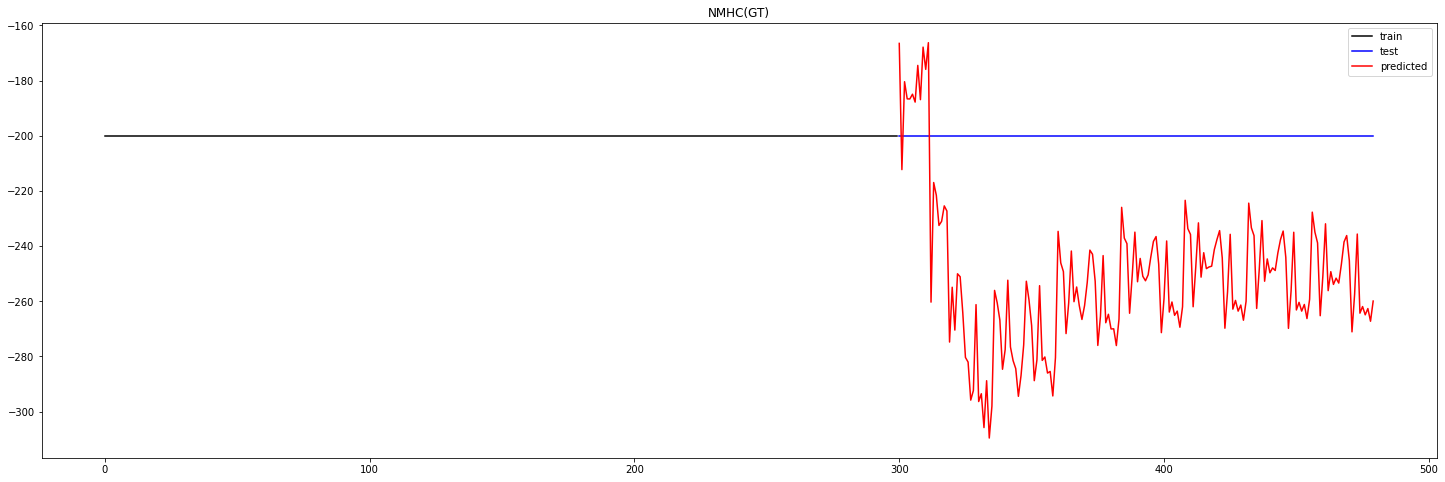

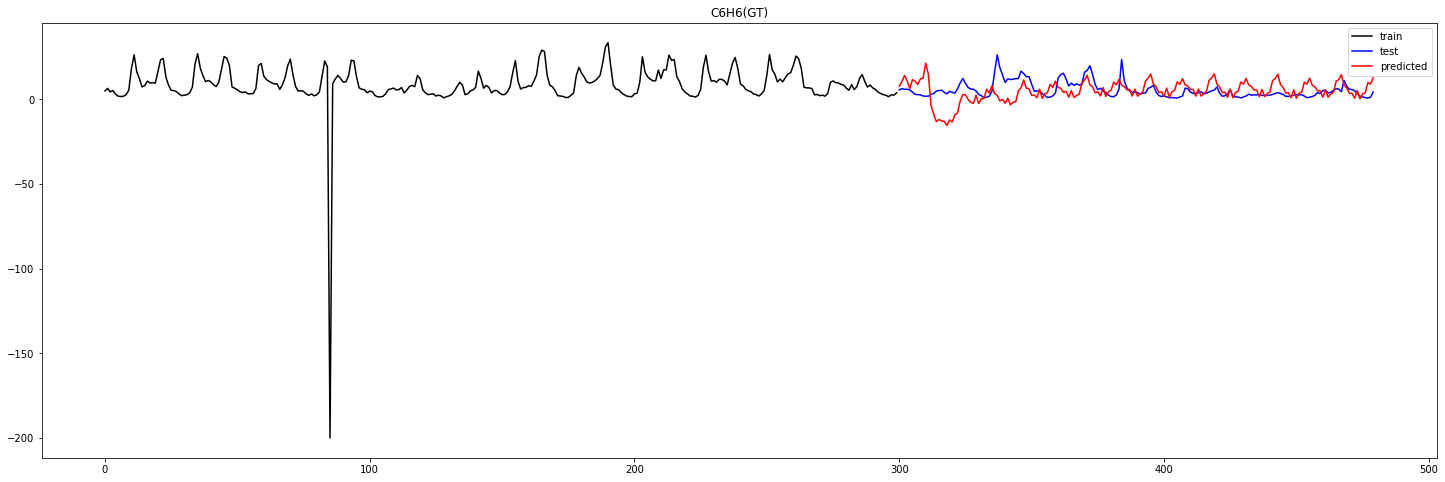

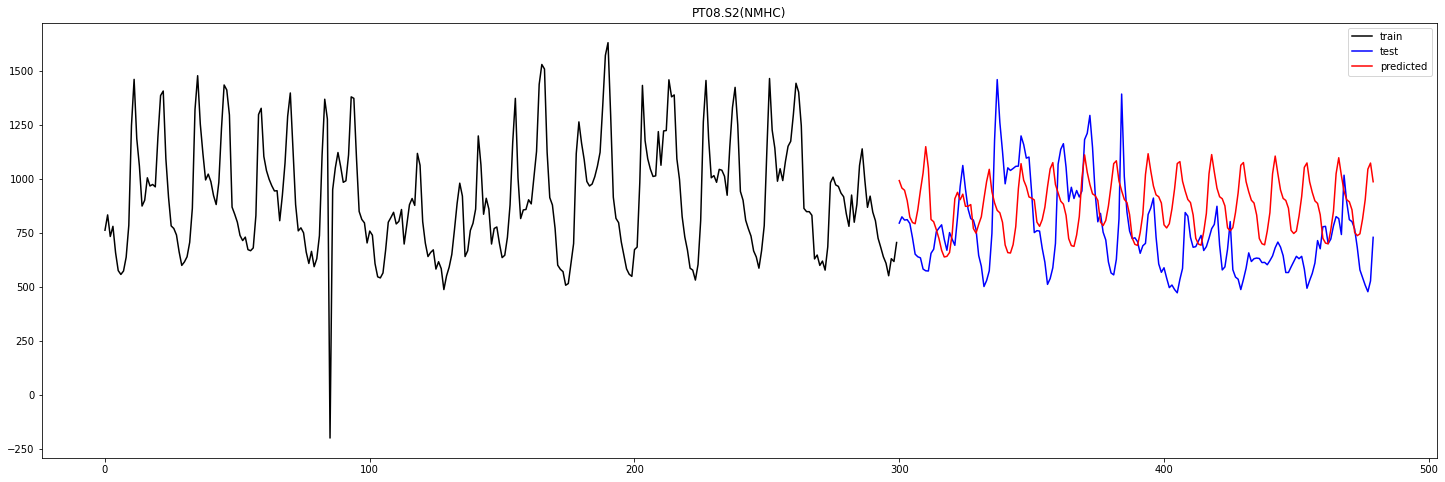

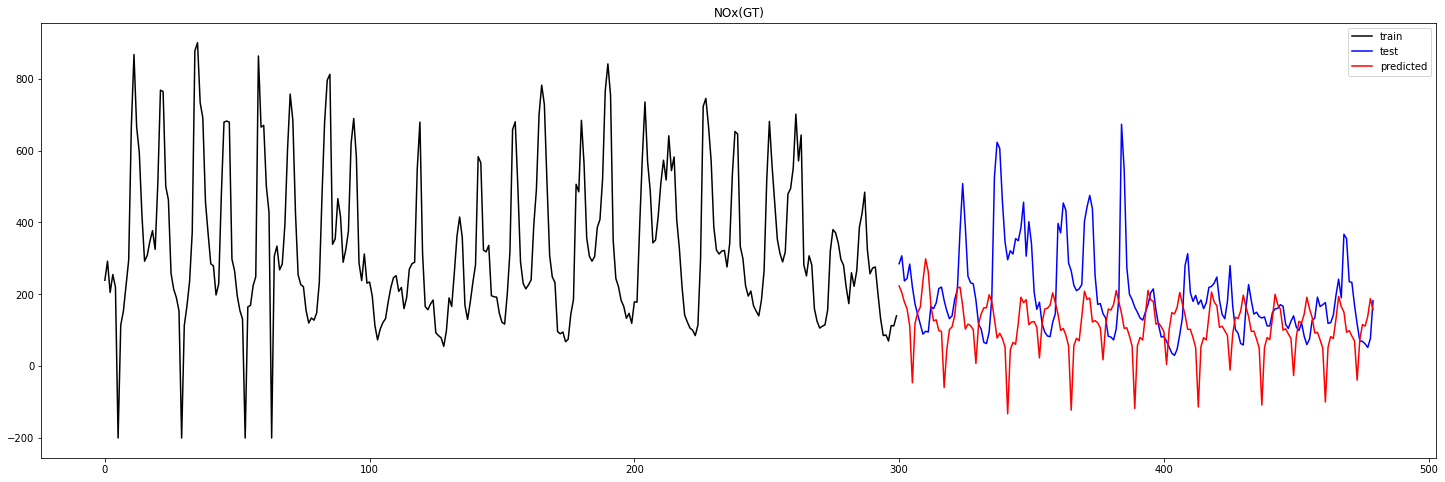

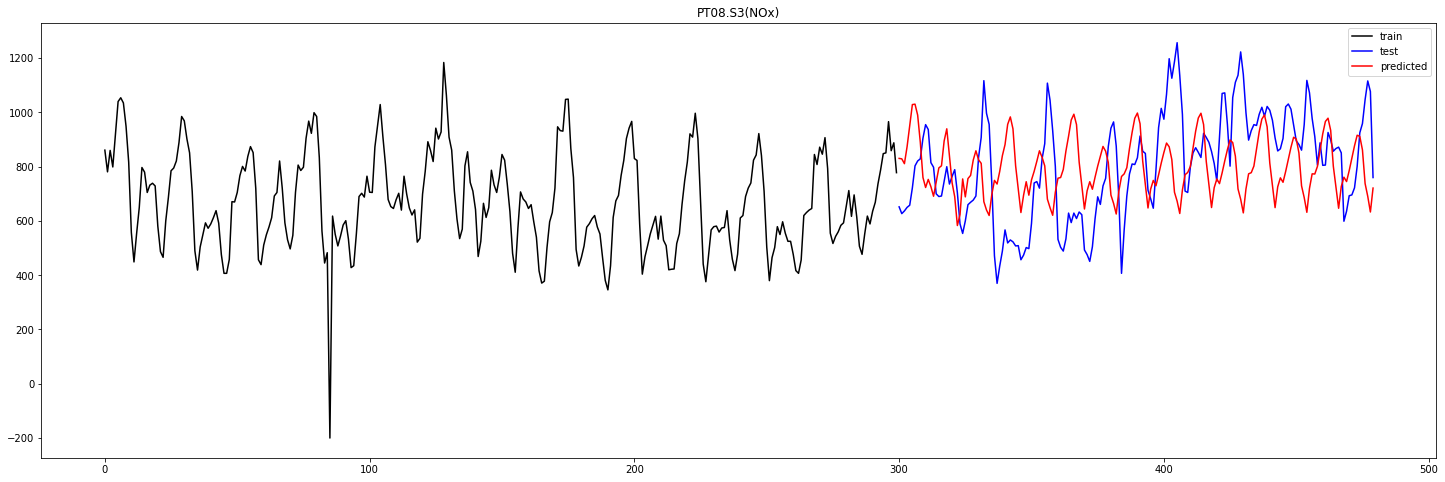

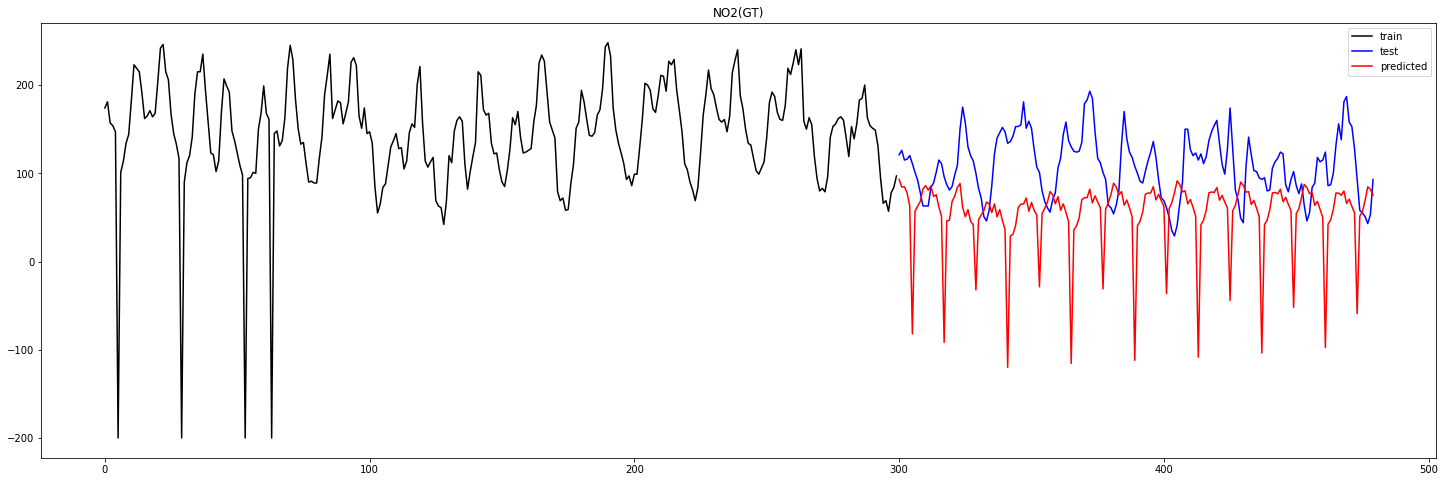

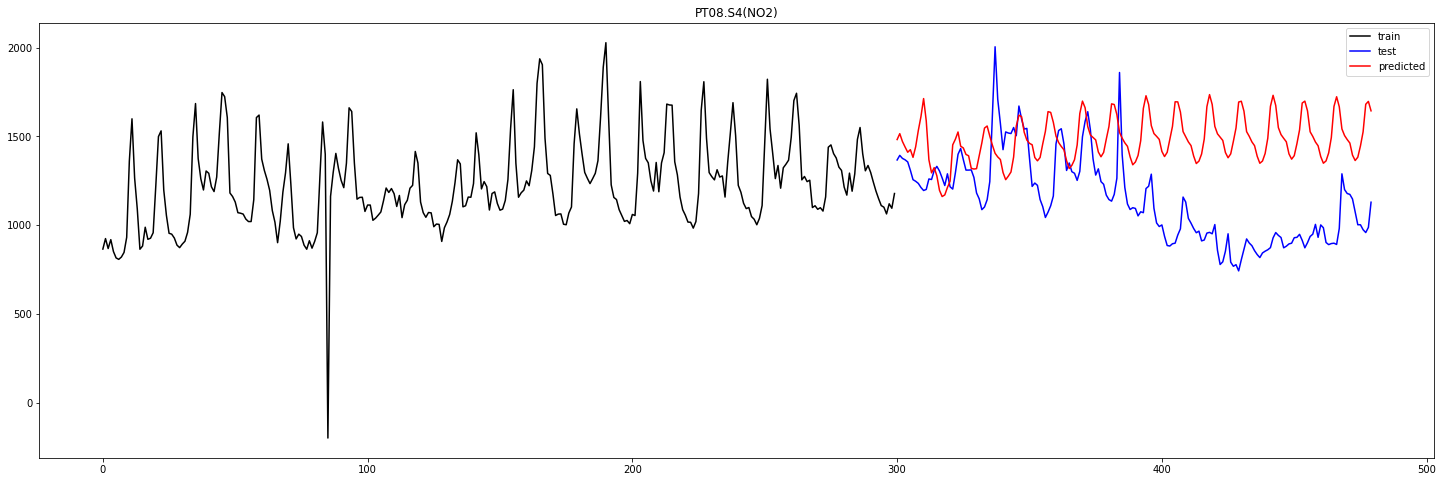

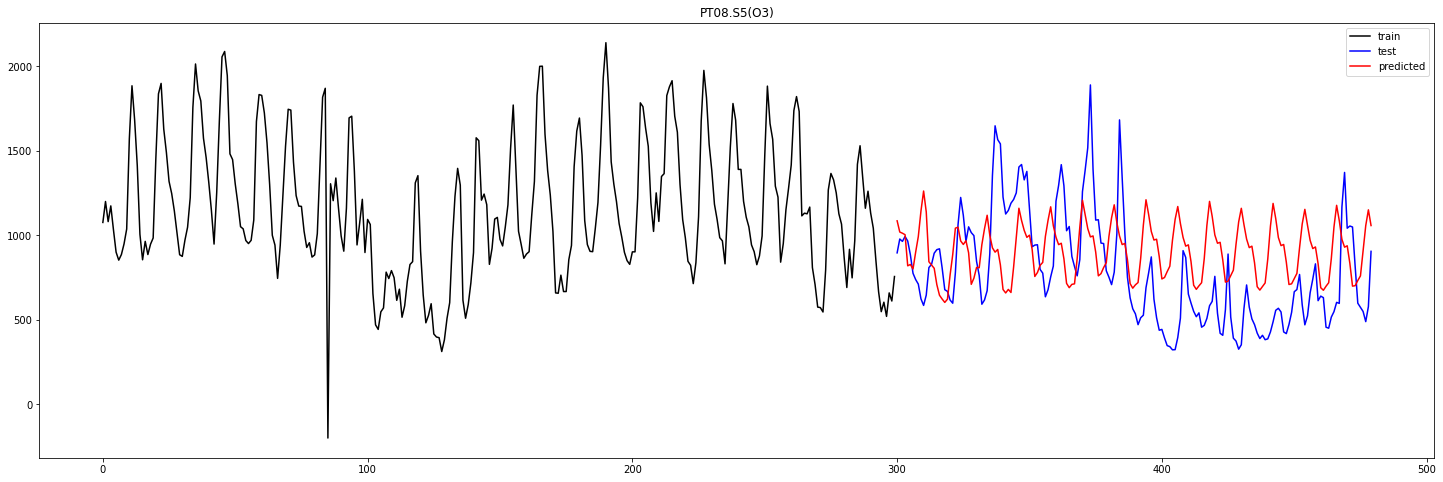

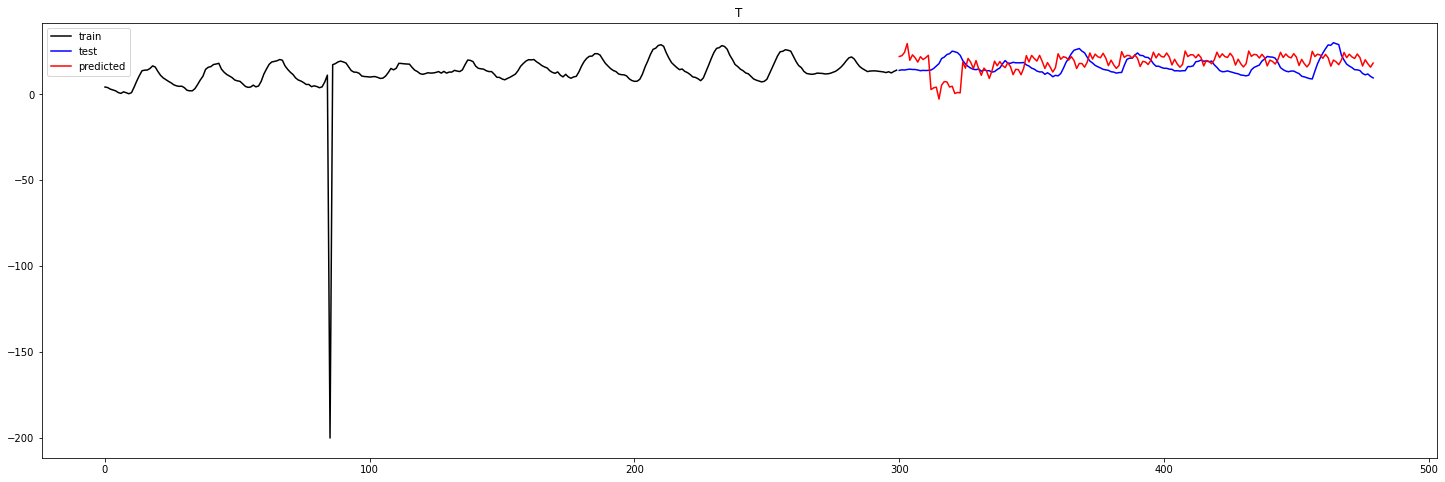

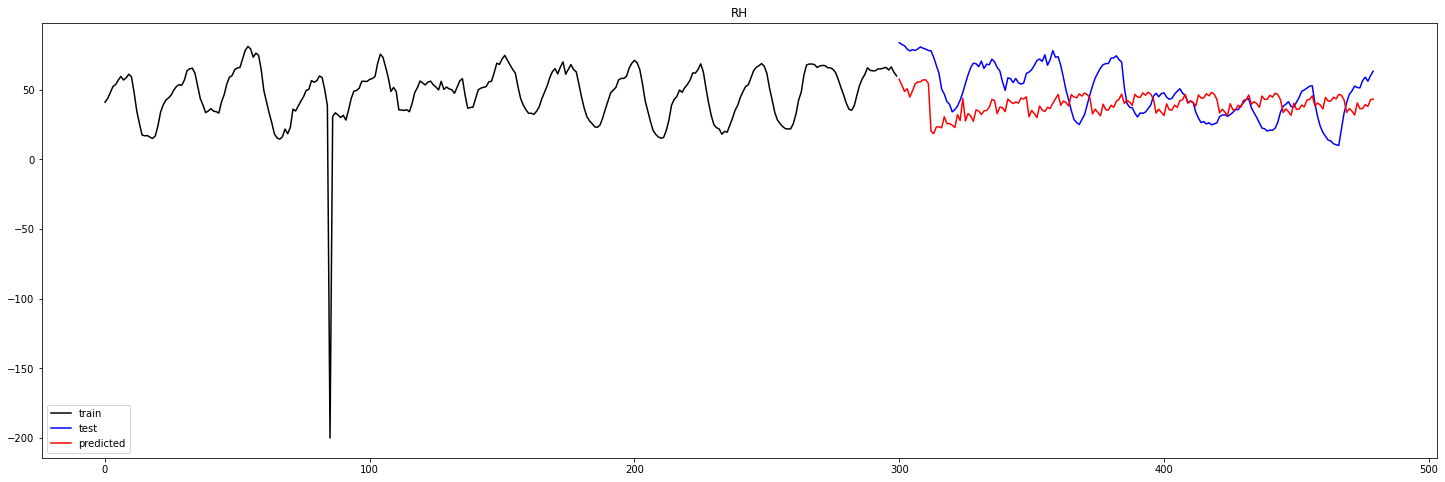

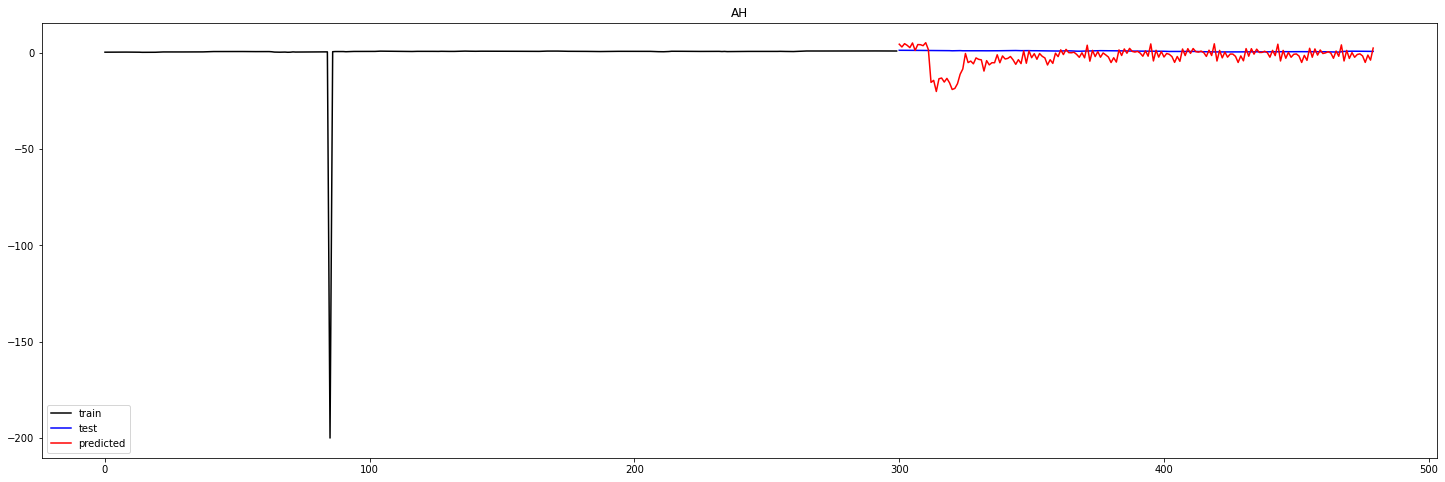

In [36]:
# for i in range(n_features):
#     plt.plot(y_test_re[:,i],color='black')
#     plt.plot(y_pred_re[:,i],color='red')
#     plt.legend(["test","predicted"])
#     plt.title(col_names[i])
#     plt.show()

plot_train_size = 300
for i in range(n_features):
    plt.figure(figsize=(25,8))
    plt.plot(range(plot_train_size),y_train_re[-plot_train_size:,i],color='black')
    plt.plot(range(plot_train_size,plot_train_size+y_test_re.shape[0]),y_test_re[:,i],color='blue')
    plt.plot(range(plot_train_size,plot_train_size+y_test_re.shape[0]),y_pred_re[:,i],color='red')
    plt.legend(["train","test","predicted"])
    plt.title(col_names[i])
    plt.show()